<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/cogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**Coupled Generative Adversarial Networks**](https://arxiv.org/abs/1606.07536)

In [1]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np


Using TensorFlow backend.


In [0]:
    def build_generators(self):

        # Shared weights between generators
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        noise = Input(shape=(self.latent_dim,))
        feature_repr = model(noise)

        # Generator 1
        g1 = Dense(1024)(feature_repr)
        g1 = LeakyReLU(alpha=0.2)(g1)
        g1 = BatchNormalization(momentum=0.8)(g1)
        g1 = Dense(np.prod(self.img_shape), activation='tanh')(g1)
        img1 = Reshape(self.img_shape)(g1)

        # Generator 2
        g2 = Dense(1024)(feature_repr)
        g2 = LeakyReLU(alpha=0.2)(g2)
        g2 = BatchNormalization(momentum=0.8)(g2)
        g2 = Dense(np.prod(self.img_shape), activation='tanh')(g2)
        img2 = Reshape(self.img_shape)(g2)

        model.summary()

        return Model(noise, img1), Model(noise, img2)

In [0]:
    def build_discriminators(self):

        img1 = Input(shape=self.img_shape)
        img2 = Input(shape=self.img_shape)

        # Shared discriminator layers
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        img1_embedding = model(img1)
        img2_embedding = model(img2)

        # Discriminator 1
        validity1 = Dense(1, activation='sigmoid')(img1_embedding)
        # Discriminator 2
        validity2 = Dense(1, activation='sigmoid')(img2_embedding)

        return Model(img1, validity1), Model(img2, validity2)

In [0]:
    def sample_images(self, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * int(c/2), 100))
        gen_imgs1 = self.g1.predict(noise)
        gen_imgs2 = self.g2.predict(noise)

        gen_imgs = np.concatenate([gen_imgs1, gen_imgs2])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [0]:
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Images in domain A and B (rotated)
        X1 = X_train[:int(X_train.shape[0]/2)]
        X2 = X_train[int(X_train.shape[0]/2):]
        X2 = scipy.ndimage.interpolation.rotate(X2, 90, axes=(1, 2))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminators
            # ----------------------

            # Select a random batch of images
            idx = np.random.randint(0, X1.shape[0], batch_size)
            imgs1 = X1[idx]
            imgs2 = X2[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a batch of new images
            gen_imgs1 = self.g1.predict(noise)
            gen_imgs2 = self.g2.predict(noise)

            # Train the discriminators
            d1_loss_real = self.d1.train_on_batch(imgs1, valid)
            d2_loss_real = self.d2.train_on_batch(imgs2, valid)
            d1_loss_fake = self.d1.train_on_batch(gen_imgs1, fake)
            d2_loss_fake = self.d2.train_on_batch(gen_imgs2, fake)
            d1_loss = 0.5 * np.add(d1_loss_real, d1_loss_fake)
            d2_loss = 0.5 * np.add(d2_loss_real, d2_loss_fake)


            # ------------------
            #  Train Generators
            # ------------------

            g_loss = self.combined.train_on_batch(noise, [valid, valid])

            # Plot the progress
            print ("%d [D1 loss: %f, acc.: %.2f%%] [D2 loss: %f, acc.: %.2f%%] [G loss: %f]" \
                % (epoch, d1_loss[0], 100*d1_loss[1], d2_loss[0], 100*d2_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

In [0]:
class COGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.d1, self.d2 = self.build_discriminators()
        self.d1.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d2.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.g1, self.g2 = self.build_generators()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img1 = self.g1(z)
        img2 = self.g2(z)

        # For the combined model we will only train the generators
        self.d1.trainable = False
        self.d2.trainable = False

        # The valid takes generated images as input and determines validity
        valid1 = self.d1(img1)
        valid2 = self.d2(img2)

        # The combined model  (stacked generators and discriminators)
        # Trains generators to fool discriminators
        self.combined = Model(z, [valid1, valid2])
        self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
                                    optimizer=optimizer)
    def build_discriminators(self):
        return build_discriminators(self)
    
    def build_generators(self):
          return build_generators(self)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        return train(self, epochs, batch_size, sample_interval)

    def sample_images(self, epoch):
      return sample_images(self, epoch)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
Total params: 160,512
Trainable params: 158,976
Non-trainable params: 1,536
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D1 loss: 0.696281, acc.: 45.31%] [D2 loss: 0.827380, acc.: 43.75%] [G loss: 1.217535]


FileNotFoundError: ignored

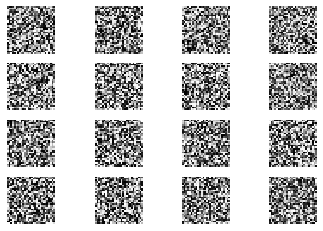

In [11]:
gan = COGAN()
gan.train(epochs=30000, batch_size=32, sample_interval=200)